# **HOSVD + Forecasting**

This algorithm is capable of predicting the behavior of fluid dynamic phenomena in future steps. This was achieved by combining Higher-order singular value decomposition (HOSVD) and Deep Learning. HOSVD is an extension of SVD for multi-dimensional tensors, the main advantage of the usage of this modal decomposition method relies on the capacity to extract patterns of the flow taking into account the strong relationships between dimensions and its compression and cleaning attributes.


---


This code has been developed using Tensorflow, specifically the Keras API. The Neural Network consists just in one LSTM layer, which is the responsible of the learning of the temporal series and a Dense layer with a linear activation function. The inputs of the neural network consist in a series of time sequences, containing the temporal coefficient for each mode.


---




Install the tensorflow 2.10.0 version.
Current versions are also supported.  


---



In [2]:
!pip install tensorflow==2.10.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.10.0




---
Install required packages.


---




In [3]:
!pip install mat73
!pip install streamlit
!pip install hdf5storage
!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 15.1 MB/s eta 0:00:00




---

Check the python and tensorflow versions.


---



In [4]:
!python --version
import tensorflow as tf
print(tf.__version__)

Python 3.11.11
2.18.0




---
Set the drive account to import the database.

---




In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/




---
Select the folder insider drive


---



In [6]:
import sys
import os

lib_folder = '/content/drive/MyDrive/Colab_Notebooks/datasets'
sys.path.append(lib_folder)



---

Import the required functions from other .py files.

---



In [7]:
import hosvd
import tfhosvd
import numpy as np
import time
import scipy.io
import mat73
import matplotlib.pyplot as plt
import tensorflow as tf



---

Import the required layers, optimizers, etc. from Keras.

---



In [8]:
### import tensorflow, keras, layers, optimizers, etc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2




---
# Definition of functions


---



In [9]:

def perform_hosvd(tensor, tolerance):

    SNAP = tensor.shape[-1]

    TimePos = tensor.ndim-1

    Tensor0 = tensor.copy()
    shapeTens = list(np.shape(tensor))
    shapeTens[-1] = SNAP
    Tensor = np.zeros(shapeTens)

    Tensor[..., :] = Tensor0[..., 0:SNAP]

    nn0 = np.array(Tensor.shape)
    nn = np.array(nn0)
    nn[1:np.size(nn)] = 0

    return hosvd.HOSVD(Tensor, tolerance, nn, nn0, TimePos)

QR normalization (This should be performed to guarantee the orthonormalization.)

In [10]:
def re_orthonormalize(tensor):
    Q,R = np.linalg.qr(tensor)
    return np.matmul(Q,R)


Rolling window function

In [11]:
def create_sequences(data, window_size, horizon):
  ''' Arguments:
  - data: Refers to the sequence of the temporal coefficients with the modes.
  - window_size: Refers to the length of the time sequence the user wants to use to train the model.
  - horizon: Refers to the number of temporal coefficients the user wants to predict over each sequence.
  '''
  X, y = [], []
  for i in range(len(data) - window_size - horizon + 1):
    X.append(data[i:i+window_size, :])  # Input window
    y.append(data[i+window_size:i+window_size+horizon, :])  # Output horizon

  return np.array(X), np.array(y)

Deep learning architecture for forecasting

In [12]:
def create_model(input_shape, output_shape): # arguments: input shape of the model, output shape of the model

    x = Input(shape= (*input_shape,))

    v = LSTM(256, return_sequences = False) (x)

    w = Dense(output_shape[0]*output_shape[1], activation = 'linear')(v)

    o = Reshape((output_shape[0],output_shape[1]))(w)

    model = Model(inputs=[x],
                  outputs=[o], name='Temporal_forecasting')
    model.compile(loss= 'mean_squared_error' , optimizer=Adam(learning_rate = 0.001 ), metrics=['mae'])

    return model

# **Main process.**

### Data loading.

Upload the tensor that is goin go to be expanded in means of time. The user can select a study region on the tensor, in order to reduce the training time and avoid the use of irrelevant information during training.

In [13]:
tensor = np.load('/content/drive/MyDrive/Colab_Notebooks/datasets/tensor_7_128_250.npy')
print(tensor.shape)

#if you are working in local use the code commented below
#tensor = np.load('tensor_7_128_250.npy')

(4, 7, 128, 128, 250)


In [14]:
#for just temporal forecasting
tensor = tensor[:,0,...]



---

Apply HOSVD to the dataset.

---



The tensor must have the shape: (n_comp, n_X, n_Y, n_t)

In [15]:
varepsilon1 = 1e-3

print('\nPerforming HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = perform_hosvd(tensor, varepsilon1)



Performing HOSVD. Please wait...



2025-01-31 09:09:45.846 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 09:09:46.888 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-01-31 09:09:46.891 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 09:09:46.894 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 09:09:46.896 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 09:09:46.898 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 09:09:46.899 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 09:09:46.901 Thread 'MainThread': mi

In [17]:
U_copy = U.copy() #Make a copy of the mode matrices tensor in order to not change the original one.

Temporal forecasting will be performed.

---



In [18]:
t_matrix = U_copy[0,3]   # extracts the matrix that corresponds to the temporal dimension.

window_size = 41 #the length of the sequence for training
horizon = 1 # the horizon the network is going to predict for each sequence.

sequence, target = create_sequences(t_matrix, window_size, horizon)

#get the train, validation and test
split_idx_1 = int(0.7 * len(sequence))
split_idx_2 = int(0.85 * len(sequence))
seq_train, seq_val, seq_test = sequence[:split_idx_1], sequence[split_idx_1:split_idx_2], sequence[split_idx_2:]
tar_train, tar_val, tar_test = target[:split_idx_1], target[split_idx_1:split_idx_2], target[split_idx_2:]

in_shape = seq_train[0].shape
out_shape = [tar_train.shape[1],tar_train.shape[2]]

##compile the model
t_forecast = create_model(in_shape, out_shape)

##fit the model
t_fit  = t_forecast.fit(seq_train, tar_train, epochs = 40, batch_size = 8, validation_data = [seq_val, tar_val])

#perform predictions
t_forecast_pred = t_forecast.predict(seq_test)

## append to the dataset
t_new_matrix = np.concatenate((t_matrix, t_forecast_pred[-1,:,:]), axis=0)

#reconstruct the tensor back into its original form.
new_tensor = hosvd.tprod(S, U_copy)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 41, 11))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.0034 - mae: 0.0507 - val_loss: 0.0020 - val_mae: 0.0363
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0017 - mae: 0.0329 - val_loss: 0.0010 - val_mae: 0.0238
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 9.3890e-04 - mae: 0.0221 - val_loss: 5.0782e-04 - val_mae: 0.0150
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 4.3495e-04 - mae: 0.0139 - val_loss: 2.0440e-04 - val_mae: 0.0094
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.5462e-04 - mae: 0.0079 - val_loss: 4.1971e-05 - val_mae: 0.0043
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 3.2767e-05 - mae: 0.0037 - val_loss: 5.6812e-06 - val_mae: 0.0018
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 4.9079e-06 - mae: 0.0016 - val_loss: 2.2170e-06 - val_mae: 0.0010
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 1.7829e-06 - mae: 9.1466e-04 - val_loss: 6.3627e-07 - val_mae: 5.3756e-04
Epoch 9/40
19/1

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 41, 11))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Text(0.5, 1.0, 'Forecasting output')

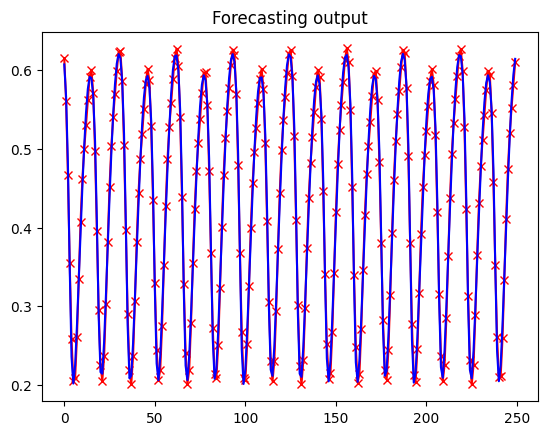

In [19]:
plt.plot(new_tensor[0,64,64,:], color = 'r', marker = 'x', label = 'predicted tensor')
plt.plot(tensor[0,64,64,:], color = 'b', label = 'original tensor')
plt.title('Forecasting output')

## **Over time prediction**



---

If the user requires to predict more than the set horizon, the function below allows to generate "n" snapshots in the future.

---



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

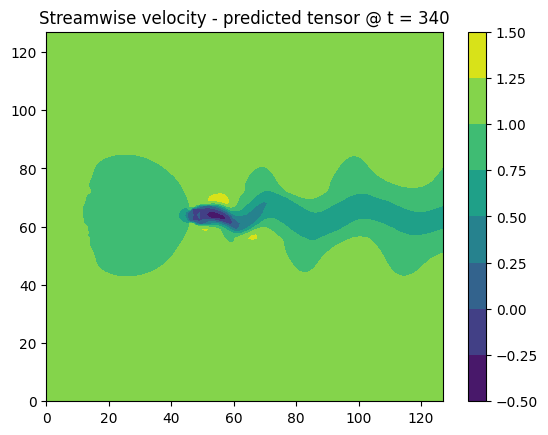

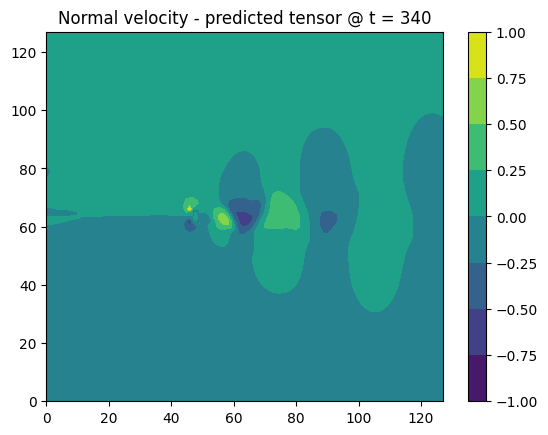

In [20]:

t_forecast_test = t_forecast.predict(seq_test[-1:,:,:])

num_iterations = 100 #number of timesteps to be predicted.
def predict_over_dataset(data, model, window_size, horizon, num_iterations):
    data = data.copy()
    new_matrix = np.zeros((num_iterations * horizon, data.shape[2]))
    idx = 0

    last_sequence = data[-1,:, :]

    for j in range(num_iterations):

        last_sequence_reshaped = last_sequence.reshape(1, window_size, data.shape[2])

        prediction = model.predict(last_sequence_reshaped)
        prediction = prediction.reshape(horizon, data.shape[2])

        new_matrix[idx:idx + horizon, :] = prediction
        idx += horizon

        last_sequence = np.concatenate([last_sequence[horizon:], prediction], axis=0)

    return new_matrix

over_matrix = predict_over_dataset(seq_test, t_forecast, window_size, horizon, num_iterations)

s_U = U.copy()


s_U[0, 3] = np.concatenate((s_U[0, 3], over_matrix), axis=0)

A = hosvd.tprod(S, s_U)

plt.contourf(A[0, :, :, -10])
plt.colorbar()
plt.title('Streamwise velocity - predicted tensor @ t = 340')
plt.show()

plt.contourf(A[1, :, :, -10])
plt.colorbar()
plt.title('Normal velocity - predicted tensor @ t = 340')
plt.show()